In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def criar_grafo_orientacao(caminho_arquivo):
    try:
        # Carregar o arquivo CSV
        # Carregar os dados do arquivo CSV, especificando a codificação
        df = pd.read_csv(caminho_arquivo, sep=';', encoding='latin-1')

        # Selecionar apenas as colunas relevantes e remover linhas com dados faltantes
        colunas_necessarias = ['DiscenteID', 'OrientadorID', 'Unidade', 'Codigo_Projeto']
        df_limpo = df[colunas_necessarias].dropna()

        # Criando uma chave única para cada combinação de DiscenteID, OrientadorID e Codigo_Projeto
        df_limpo['chave_unica'] = df_limpo['DiscenteID'].astype(str) + '_' + df_limpo['OrientadorID'].astype(str) + '_' + df_limpo['Codigo_Projeto'].astype(str)

        # Remover duplicatas com base nesta chave única
        df_processado = df_limpo.drop_duplicates(subset=['chave_unica']).copy()

        # Cria listas de identificadores únicos com prefixos, para evitar conflitos de nomes de nós no grafo
        discentes = ['discente_' + str(i) for i in df_processado['DiscenteID'].unique()]
        orientadores = ['orientador_' + str(i) for i in df_processado['OrientadorID'].unique()]
        departamentos = ['departamento_' + str(i) for i in df_processado['Unidade'].unique()]

        # Criando grafo
        G = nx.Graph()
        G.add_nodes_from(discentes, bipartite='discente')
        G.add_nodes_from(orientadores, bipartite='orientador')
        G.add_nodes_from(departamentos, bipartite='departamento')

        # Adicionando arestas com prefixos
        for _, row in df_processado.iterrows():
            G.add_edge(
                'discente_' + str(row['DiscenteID']),
                'orientador_' + str(row['OrientadorID']),
                tipo='orientacao'
            )

        # Arestas orientador <-> departamento
        pesos = df_processado.groupby(['OrientadorID', 'Unidade']).size().reset_index(name='peso')
        for _, row in pesos.iterrows():
            G.add_edge(
                'orientador_' + str(row['OrientadorID']),
                'departamento_' + str(row['Unidade']),
                peso=row['peso'],
                tipo='afiliacao'
            )

        # Imprimir informações sobre o grafo
        print(f"Número total de nós: {G.number_of_nodes()}")
        print(f"Número total de arestas: {G.number_of_edges()}")
        print(f"A densidade do grafo: {nx.density(G)}")
        return G # Retornar o grafo corrigido

    except FileNotFoundError:
        print(f"Erro: O arquivo '{caminho_arquivo}' não foi encontrado. Verifique o nome e o caminho do arquivo.")
        return None
    except Exception as e:
        print(f"Ocorreu um erro: {e}")
        return None

# Exemplo de como usar a função com o seu arquivo
caminho_do_seu_arquivo = "./Iniciação_Ciêntifica - Dados Abertos.csv"
grafo_final = criar_grafo_orientacao(caminho_do_seu_arquivo)

Número total de nós: 28219
Número total de arestas: 33618
A densidade do grafo: 8.443723820245974e-05


In [2]:
if grafo_final:

    # Separar nós por tipo usando sets para melhor performance
    orientadores = set(node for node, data in grafo_final.nodes(data=True) if data.get('bipartite') == 'orientador')
    discentes = set(node for node, data in grafo_final.nodes(data=True) if data.get('bipartite') == 'discente')
    departamentos = set(node for node, data in grafo_final.nodes(data=True) if data.get('bipartite') == 'departamento')

    # Professor com mais orientandos - usando intersection para melhor performance
    contagem_discentes_por_orientador = {
        orientador: len(set(grafo_final.neighbors(orientador)) & discentes)
        for orientador in orientadores
    }

    orientador_mais_discentes = max(contagem_discentes_por_orientador, key=contagem_discentes_por_orientador.get)
    max_discentes = contagem_discentes_por_orientador[orientador_mais_discentes]

    # Extrair apenas o ID numérico
    orientador_mais_discentes_id = orientador_mais_discentes.split('_')[1]

    print(f"\nProfessor com mais orientandos:")
    print(f"ID do Professor: {orientador_mais_discentes_id}")
    print(f"Número de orientandos: {max_discentes}")

    # Departamento com mais discentes - otimizado
    contagem_discentes_por_departamento = {}
    for departamento in departamentos:
        # Encontrar orientadores associados a este departamento
        orientadores_do_departamento = set(grafo_final.neighbors(departamento)) & orientadores

        # Contar discentes únicos associados a esses orientadores
        discentes_do_departamento = set()
        for orientador in orientadores_do_departamento:
            discentes_do_departamento.update(set(grafo_final.neighbors(orientador)) & discentes)

        contagem_discentes_por_departamento[departamento] = len(discentes_do_departamento)

    departamento_mais_discentes = max(contagem_discentes_por_departamento, key=contagem_discentes_por_departamento.get)
    max_discentes_departamento = contagem_discentes_por_departamento[departamento_mais_discentes]

    print(f"\nDepartamento com mais discentes de iniciação científica:")
    print(f"Departamento: {departamento_mais_discentes}")
    print(f"Número total de discentes associados: {max_discentes_departamento}")

    # Top 5 Orientadores por grau
    graus_orientadores = {orientador: grafo_final.degree(orientador) for orientador in orientadores}
    orientadores_top_grau = sorted(graus_orientadores.items(), key=lambda item: item[1], reverse=True)[:5]

    print("\nTop 5 Orientadores por número total de conexões (Grau):")
    for orientador, grau in orientadores_top_grau:
        # Extrair apenas o ID numérico para exibição
        orientador_id = orientador.split('_')[1]
        print(f"  Orientador ID: {orientador_id}, Grau: {grau}")

    # Top 5 Departamentos por grau
    graus_departamentos = {departamento: grafo_final.degree(departamento) for departamento in departamentos}
    departamentos_top_grau = sorted(graus_departamentos.items(), key=lambda item: item[1], reverse=True)[:5]

    print("\nTop 5 Departamentos por número de conexões com Orientadores (Grau):")
    for departamento, grau in departamentos_top_grau:
        print(f"  Departamento: {departamento}, Grau: {grau}")

else:
    print("O grafo não foi criado. Por favor rode as células anteriores.")


Professor com mais orientandos:
ID do Professor: 5752963
Número de orientandos: 97

Departamento com mais discentes de iniciação científica:
Departamento: departamento_CENTRO DE CIÊNCIAS DA SAÚDE - CCS
Número total de discentes associados: 2468

Top 5 Orientadores por número total de conexões (Grau):
  Orientador ID: 5752963, Grau: 99
  Orientador ID: 25939, Grau: 85
  Orientador ID: 23112, Grau: 76
  Orientador ID: 25847, Grau: 74
  Orientador ID: 22014, Grau: 70

Top 5 Departamentos por número de conexões com Orientadores (Grau):
  Departamento: departamento_CENTRO DE CIÊNCIAS DA SAÚDE - CCS, Grau: 129
  Departamento: departamento_ESCOLA AGRÍCOLA DE JUNDIAÍ - EAJ, Grau: 127
  Departamento: departamento_CENTRO DE CIÊNCIAS HUMANAS, LETRAS E ARTES - CCHLA, Grau: 127
  Departamento: departamento_FACULDADE DE CIÊNCIAS DA SAÚDE DO TRAIRI - FACISA - FACISA, Grau: 126
  Departamento: departamento_ESCOLA DE CIÊNCIAS E TECNOLOGIA - ECT, Grau: 118


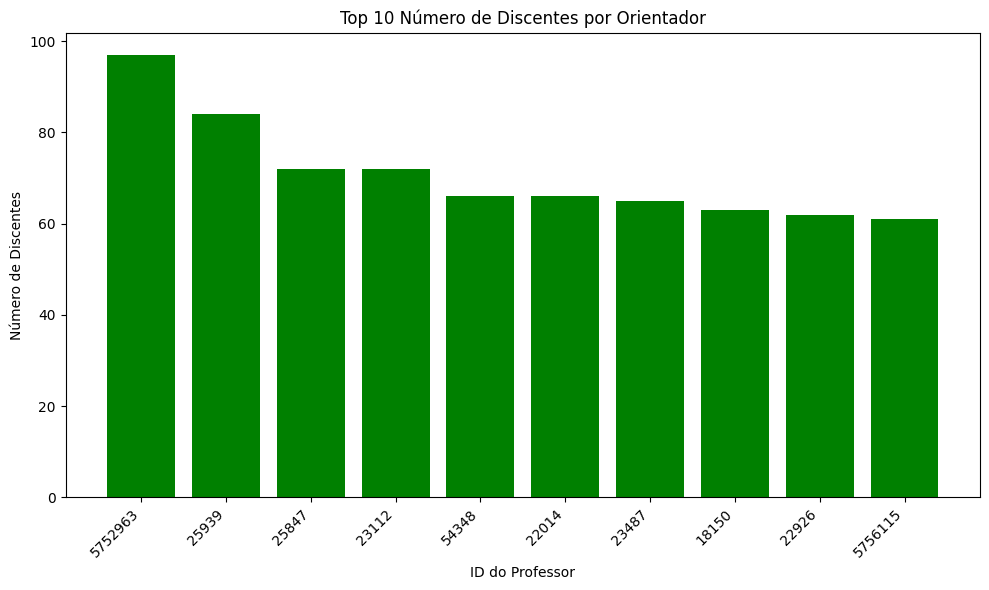

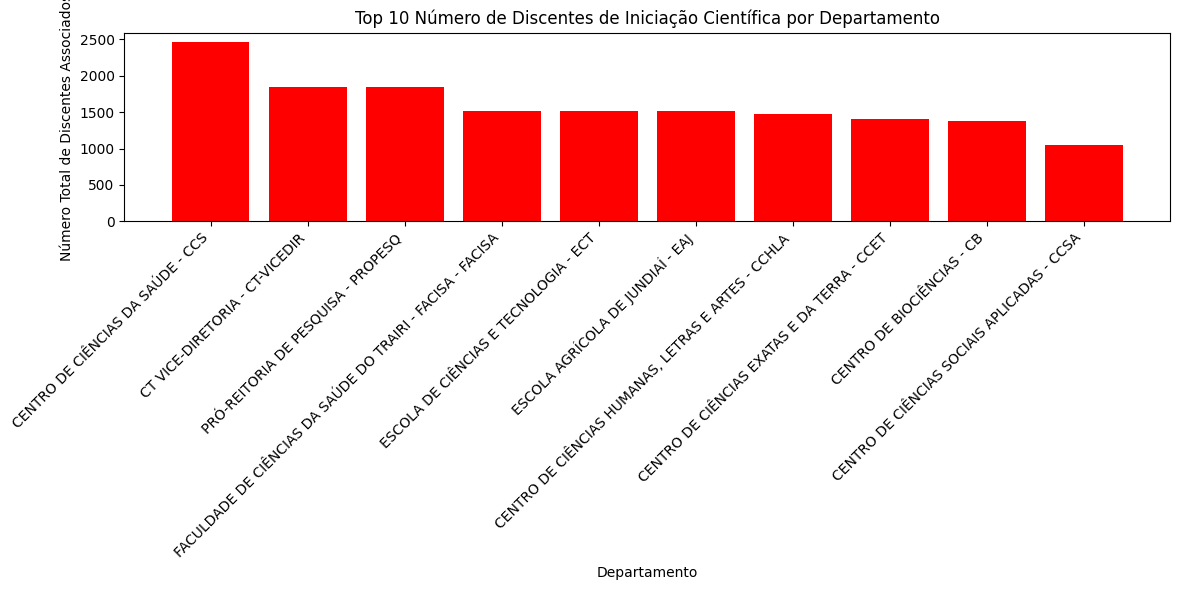

In [3]:
# Análise gráfica dos resultados
import collections

if grafo_final:

    # Gráfico 1: Top N Professores por número de Orientandos
    # Converter o dicionário para Series para facilitar a ordenação e seleção
    serie_orientadores_discentes = pd.Series(contagem_discentes_por_orientador)

    # Pegar os top N (vamos usar 10 como exemplo, pode ajustar)
    top_n = 10
    # Filtrar para orientadores que estão no grafo_final (caso o grafo tenha sido filtrado)
    top_orientadores = serie_orientadores_discentes[serie_orientadores_discentes.index.isin([node for node, data in grafo_final.nodes(data=True) if data.get('bipartite') == 'orientador'])].sort_values(ascending=False).head(top_n)

    # Extrair apenas o ID numérico para os rótulos do eixo x
    orientador_ids = [id.split('_')[1] for id in top_orientadores.index]

    plt.figure(figsize=(10, 6))
    # Usar os IDs numéricos como rótulos do eixo x
    plt.bar(orientador_ids, top_orientadores.values, color='green')
    plt.title(f'Top {top_n} Número de Discentes por Orientador')
    plt.xlabel('ID do Professor')
    plt.ylabel('Número de Discentes')
    plt.xticks(rotation=45, ha='right') # Rotação para IDs longos
    plt.tight_layout() # Ajusta o layout para evitar cortes
    plt.show()

    # Print de espaço
    print()

    # Gráfico 2: Top N Departamentos por número de Discentes
    # Converter o dicionário para Series
    serie_departamentos_discentes = pd.Series(contagem_discentes_por_departamento)

    # Pegar os top N (vamos usar 10 como exemplo, pode ajustar)
    # Filtrar para departamentos que estão no grafo_final
    top_departamentos = serie_departamentos_discentes[serie_departamentos_discentes.index.isin([node for node, data in grafo_final.nodes(data=True) if data.get('bipartite') == 'departamento'])].sort_values(ascending=False).head(top_n)

    # Extrair apenas o nome do departamento
    departamento_nomes = [dep.split('_', 1)[1] if '_' in dep else dep for dep in top_departamentos.index]


    plt.figure(figsize=(12, 6))
    # Usar os nomes dos departamentos como rótulos do eixo x
    plt.bar(departamento_nomes, top_departamentos.values, color='red')
    plt.title(f'Top {top_n} Número de Discentes de Iniciação Científica por Departamento')
    plt.xlabel('Departamento')
    plt.ylabel('Número Total de Discentes Associados')
    plt.xticks(rotation=45, ha='right') # Rotação para nomes longos
    plt.tight_layout()
    plt.show()

else:
    print("O grafo não foi criado. Por favor rode as células anteriores.")

=== ANÁLISE DE DISTRIBUIÇÃO - DISCENTES ===
Total de Discentes: 25424
Grau médio dos discentes: 1.17
Grau mínimo: 1
Grau máximo: 5

=== ANÁLISE DE DISTRIBUIÇÃO - PROFESSORES ===
Total de professores: 2558
Número médio de orientandos: 11.65
Mínimo de orientandos: 1
Máximo de orientandos: 97



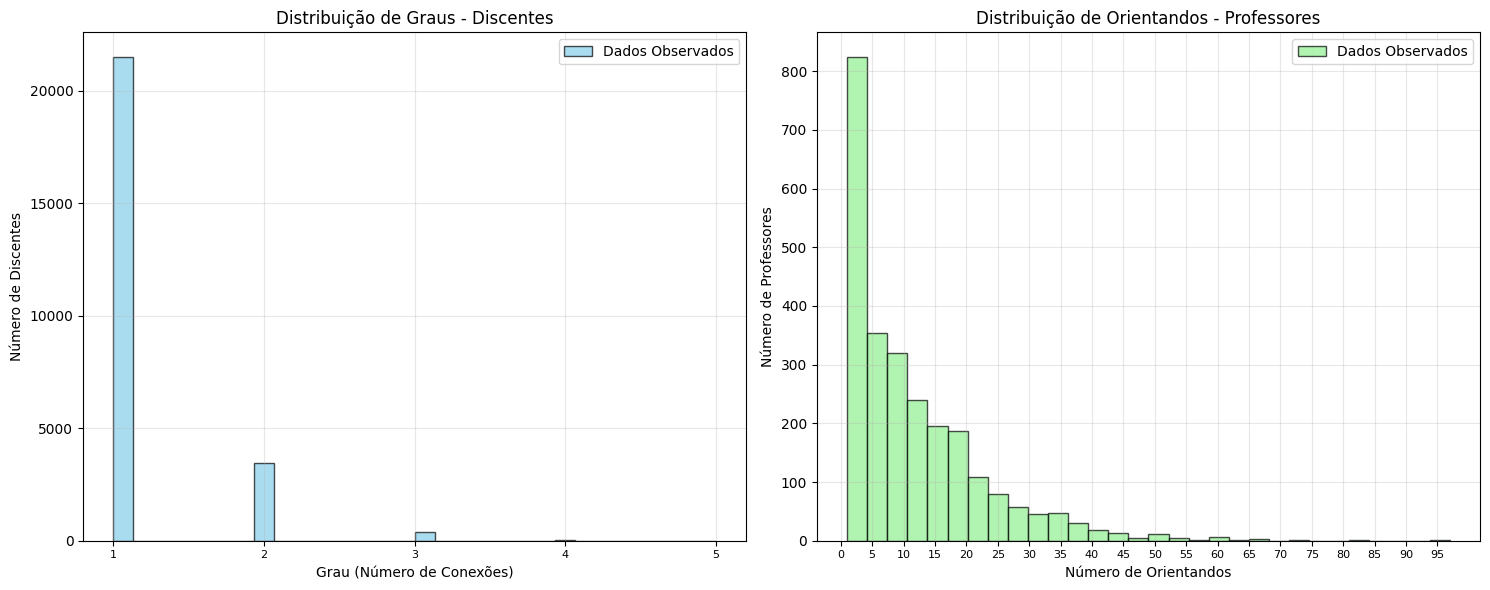

In [5]:
# Análise de Distribuição Normal - Discentes e Professores

import numpy as np
from scipy import stats

if grafo_final:

    # Análise 1: Distribuição Normal para Discentes (grau de conexão)
    # Calcular graus apenas dos discentes
    graus_discentes = [grafo_final.degree(node) for node, data in grafo_final.nodes(data=True)
                      if data.get('bipartite') == 'discente']

    # Estatísticas dos discentes
    media_discentes = np.mean(graus_discentes)
    desvio_discentes = np.std(graus_discentes)

    print(f"=== ANÁLISE DE DISTRIBUIÇÃO - DISCENTES ===")
    print(f"Total de Discentes: {len(graus_discentes)}")
    print(f"Grau médio dos discentes: {media_discentes:.2f}")
    print(f"Grau mínimo: {min(graus_discentes)}")
    print(f"Grau máximo: {max(graus_discentes)}")
    print()

    # Análise 2: Distribuição Normal para Professores (número de orientandos)
    # Usar os dados já calculados de contagem_discentes_por_orientador
    orientandos_por_professor = list(contagem_discentes_por_orientador.values())

    # Estatísticas dos professores
    media_professores = np.mean(orientandos_por_professor)
    desvio_professores = np.std(orientandos_por_professor)

    print(f"=== ANÁLISE DE DISTRIBUIÇÃO - PROFESSORES ===")
    print(f"Total de professores: {len(orientandos_por_professor)}")
    print(f"Número médio de orientandos: {media_professores:.2f}")
    print(f"Mínimo de orientandos: {min(orientandos_por_professor)}")
    print(f"Máximo de orientandos: {max(orientandos_por_professor)}")
    print()

    # Visualizações lado a lado
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Gráfico 1: Histograma + Curva Normal - Discentes
    ax1.hist(graus_discentes, bins=30, density=False, alpha=0.7, color='skyblue',
             edgecolor='black', label='Dados Observados')

    ax1.set_title('Distribuição de Graus - Discentes')
    ax1.set_xlabel('Grau (Número de Conexões)')
    ax1.set_ylabel('Número de Discentes')
    ax1.set_xticks(range(int(min(graus_discentes)), int(max(graus_discentes)) + 1, 1))
    ax1.tick_params(axis='x', labelsize=8)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Gráfico 2: Histograma + Curva Normal - Professores
    ax2.hist(orientandos_por_professor, bins=30, density=False, alpha=0.7, color='lightgreen',
             edgecolor='black', label='Dados Observados')

    ax2.set_title('Distribuição de Orientandos - Professores')
    ax2.set_xlabel('Número de Orientandos')
    ax2.set_ylabel('Número de Professores')
    ax2.set_xticks(range(0, int(max(orientandos_por_professor)) + 1, 5))
    ax2.tick_params(axis='x', labelsize=8)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

else:
    print("O grafo não foi criado. Execute as células anteriores primeiro.")